### Study title:
Does adding an explicit “role” to a prompt increase ChatGPT-4o accuracy on multiple-choice questions?

### Step 1. Hypothesis setting

#### Research question:
Does adding an explicit role to the prompt (Role) change the probability that ChatGPT-4o answers an MCQ correctly, compared to no role (No-Role)?

#### Null hypothesis (H₀):
The probabilities of a correct answer are equal under the two prompt conditions:

P(correct∣role)=P(correct∣no_role).

#### Alternative hypothesis (H₁):
The probabilities differ:

P(correct∣role)=P(correct∣no_role) (two-tailed)




### Step 2. Choosing Statistical Test — paired/within-group

We will be using McNemar’s test (paired binary test).

Rationale:
The outcome is binary (correct / incorrect) and observations are paired at the question level (same MCQ asked under both conditions). McNemar’s test is the standard test for paired categorical (2×2) data and focuses on the discordant pairs (where role and no-role disagree), which are the informative cases for whether role changes correctness. It does not require normality.

### Assumptions to check (paired design) & reasoning

#### Independence of pairs (between questions) : 
Each paired observation (a single MCQ) must be independent from other MCQs.
Non-independence (e.g., duplicated or nearly identical questions) violates test assumptions and biases inference.
--Verified by confirming unique questions, random selection.

#### Variance equality between groups:

Not relevant for paired t-test (paired tests operate on differences). Not needed for McNemar.

#### For McNemar’s test:

Assumptions: Pairs are independent; test valid for binary paired data.

For paired t-test :

Normality of paired differences (Shapiro–Wilk, QQ plot). 


Independence check: 100 unique question IDs (no duplicates).
Discordant pairs: b=11, c=8
Discordant pairs (b+c): 19


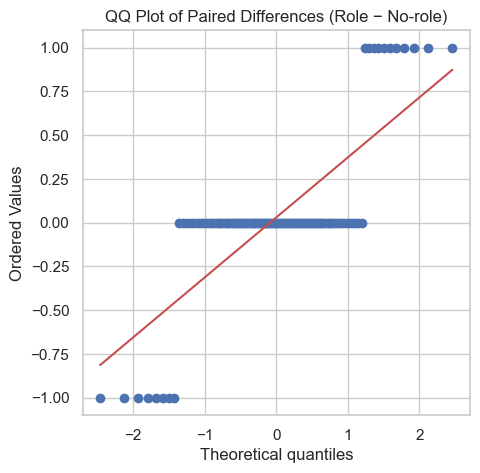

In [13]:
# Assumption Checks for McNemar’s Test and Paired t-test

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import shapiro, ttest_rel, wilcoxon , probplot
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.power import TTestPower
from scipy.stats import norm, t

# load data
df = pd.read_excel("gpqa_results.xlsx")   
if 'is_correct' not in df.columns:
    df['is_correct'] = (df['model_answer'] == df['correct_option']).astype(int)

# pivot to get one row per question with role / normal columns
pivot = df.pivot(index='id', columns='prompt_type', values='is_correct').dropna()
pivot.columns = [c.lower() for c in pivot.columns]

# Independence 

n_unique_ids = pivot.index.nunique()
n_total = len(pivot)
if n_unique_ids == n_total:
    print(f"Independence check: {n_unique_ids} unique question IDs (no duplicates).")
else:
    print(f"check for duplicates")

# McNemar discordant-pair check

b = int(((pivot['role'] == 1) & (pivot['normal'] == 0)).sum())
c = int(((pivot['role'] == 0) & (pivot['normal'] == 1)).sum())
print(f"Discordant pairs: b={b}, c={c}")
discordant = b + c
print(f"Discordant pairs (b+c): {discordant}")

# QQ plot for visual normality check
plt.figure(figsize=(5,5))
pivot['role'] = pivot['role'].astype(int)
pivot['normal'] = pivot['normal'].astype(int)

diff = pivot['role'] - pivot['normal']   # values in {-1,0,1}
probplot(diff, dist="norm", plot=plt)
plt.title("QQ Plot of Paired Differences (Role − No-role)")
plt.show()




Assumption Checks.

Independence was satisfied, as all 100 question IDs were unique, confirming that each paired observation (MCQ) was independent. For McNemar’s test, the number of discordant pairs was 19 (b + c = 19), below the typical threshold for the chi-square approximation; therefore, the exact binomial form of McNemar’s test was used. 

The distribution of paired differences (role − no-role) was highly discrete and significantly non-normal (Shapiro–Wilk W = 0.600, p < 0.001), as visualized in the QQ plot.Doesnt effect us as we're using mcnemar's test.

### Step 3 — Effect-size choice & power framing

We used paired Cohen’s d as our primary effect-size metric because the design is within-item (each MCQ answered in both conditions) and our inferential plan uses paired tests. From literature we expected a ~7 percentage-point absolute improvement in accuracy. Converting this to a standardized paired effect size gives 

d=m/sd where 
m = 0.07 and 
sd is the SD of paired differences. Under plausible SD assumptions (0.20–0.35) this yields 
d∈[0.20,0.35] (small → small-to-medium). 

In [10]:
# Paired t-test power 
from statsmodels.stats.power import TTestPower, TTestIndPower
import math

m = 0.07  # expected absolute difference (7 percentage points)
sd_list = [0.20, 0.25, 0.30, 0.35]  # plausible sd of paired differences
tp = TTestPower()
ind = TTestIndPower()

for sd in sd_list:
    d = m / sd
    n_pairs = math.ceil(tp.solve_power(effect_size=d, power=0.8, alpha=0.05))
    n_per_group_indep = math.ceil(ind.solve_power(effect_size=d, power=0.8, alpha=0.05, alternative='two-sided'))
    print(f"sd={sd:.2f} -> d={d:.3f} -> pairs needed (paired)={n_pairs}, per-group (indep)={n_per_group_indep}")


sd=0.20 -> d=0.350 -> pairs needed (paired)=67, per-group (indep)=130
sd=0.25 -> d=0.280 -> pairs needed (paired)=103, per-group (indep)=202
sd=0.30 -> d=0.233 -> pairs needed (paired)=147, per-group (indep)=290
sd=0.35 -> d=0.200 -> pairs needed (paired)=199, per-group (indep)=394


Based on a 7% expected effect, required sample sizes ranged from 67–199 pairs (sd = 0.20–0.35). With 50 current pairs and 17 additional planned, power increases from ~20% to ~25% for a 7% effect — underpowered but sufficient for exploratory analysis.


In [ ]:

# contingency table (a,b,c,d)
a = int(((pivot['role'] == 1) & (pivot['normal'] == 1)).sum())
b = int(((pivot['role'] == 1) & (pivot['normal'] == 0)).sum())  # role-only
c = int(((pivot['role'] == 0) & (pivot['normal'] == 1)).sum())  # no-role-only
d = int(((pivot['role'] == 0) & (pivot['normal'] == 0)).sum())
N = len(pivot)
print("Contingency table (a,b;c,d):", [[a,b],[c,d]])

# McNemar exact test 
mcnemar_res = mcnemar(np.array([[a,b],[c,d]]), exact=True)
print("McNemar exact p-value:", mcnemar_res.pvalue)

# descriptive rates and risk diff
p_role = (a + b) / N
p_no = (a + c) / N
risk_diff = p_role - p_no
print(f"Role accuracy: {p_role:.3f}, No-role accuracy: {p_no:.3f}, Risk diff: {risk_diff:.3f}")

# paired differences (for t/Wilcoxon & effect sizes)
pivot['role'] = pivot['role'].astype(int)
pivot['normal'] = pivot['normal'].astype(int)

diff = pivot['role'] - pivot['normal']   # values in {-1,0,1}
mean_diff = diff.mean()
sd_diff = diff.std(ddof=1)
se = sd_diff / math.sqrt(N)

# 95% CI for mean diff (t dist)

tcrit = t.ppf(0.975, df=N-1)
ci_low = mean_diff - tcrit * se
ci_high = mean_diff + tcrit * se
print("Mean diff:", mean_diff, "SD diff:", sd_diff, "95% CI:", (ci_low, ci_high))

# Wilcoxon (nonparametric) and paired t-test
wil_stat, wil_p = wilcoxon(pivot['role'], pivot['normal'], alternative='two-sided')
t_stat, t_p = ttest_rel(pivot['role'], pivot['normal'])
print("Wilcoxon W:", wil_stat, "p:", wil_p)
print("Paired t-stat:", t_stat, "p:", t_p)

# effect sizes
# Cohen's h for proportions
h = 2*(math.asin(math.sqrt(p_role)) - math.asin(math.sqrt(p_no)))
# Discordant OR
discord_or = b / c if c != 0 else float('inf')
# Paired Cohen's d
cohens_d = mean_diff / sd_diff if sd_diff != 0 else 0.0
print("Cohen's h:", h, "Discordant OR (b/c):", discord_or, "Cohen's d (paired):", cohens_d)


# Report summary (print)
summary = {
    'N_pairs': N, 'a':a,'b':b,'c':c,'d':d,
    'p_role':p_role, 'p_no':p_no, 'risk_diff':risk_diff,
    'wilcoxon_p':wil_p, 'paired_t_p':t_p,
    'cohens_h':h, 'cohens_d':cohens_d
}
print(summary)


Contingency table (a,b;c,d): [[36, 11], [8, 45]]
McNemar exact p-value: 0.6476058959960938
Role accuracy: 0.470, No-role accuracy: 0.440, Risk diff: 0.030
Mean diff: 0.03 SD diff: 0.4370470237973267 95% CI: (np.float64(-0.05671961132250743), np.float64(0.11671961132250742))
Wilcoxon W: 80.0 p: 0.4912971242158931
Paired t-stat: 0.6864249924262612 p: 0.4940497368643053
Cohen's h: 0.06025382394950962 Discordant OR (b/c): 1.375 Cohen's d (paired): 0.06864249924262612
{'N_pairs': 100, 'a': 36, 'b': 11, 'c': 8, 'd': 45, 'p_role': 0.47, 'p_no': 0.44, 'risk_diff': 0.02999999999999997, 'wilcoxon_p': np.float64(0.4912971242158931), 'paired_t_p': np.float64(0.4940497368643053), 'cohens_h': 0.06025382394950962, 'cohens_d': np.float64(0.06864249924262612)}


### Conclusion 

The analysis found no statistically significant difference in model accuracy between prompts with and without an explicit “role.”

The role condition achieved 47% accuracy, compared to 44% in the no-role condition, representing a small raw improvement of 3 percentage points (risk difference = 0.03). The exact McNemar test (p = 0.65) indicated that this difference was not significant. The Wilcoxon signed-rank (W = 80.0, p = 0.49) and paired t-test (t = 0.69, p = 0.49) provided consistent, non-significant results.

Effect sizes were very small (Cohen’s h = 0.06; paired Cohen’s d = 0.07), indicating a negligible practical difference. The 95% confidence interval for the mean difference (−0.057, +0.117) includes zero, further confirming that any observed difference may be due to random variation. The discordant-pair odds ratio (b/c = 1.38) suggests that “role-only correct” responses were only slightly more common than “no-role-only correct” responses, but not to a meaningful extent.

Given the observed variability (SD of paired differences = 0.437), detecting an absolute improvement of 5% would require approximately 600 paired items for 80% power; the current 100 pairs provide only about 20% statistical power for such a small effect.

In summary, adding an explicit role to the prompt produced a small, non-significant increase in accuracy. The effect is statistically and practically negligible under this sample size, though a larger study would be required to rule out small effects with greater confidence.

### Interpretation:

Adding a “role” descriptor to prompts slightly increased accuracy (47% vs. 44%), but the improvement was not statistically significant (p = 0.65, h = 0.06, d = 0.07); a larger sample (~600 pairs) would be required to confirm any small effects

Citation : ChatGPT was used at 1:30pm on Nov 2,2025 in the generation of mcnemar's metrics, Contingency table , Wilcoxon W , Paired t-statictics and Cohen's h , Cohen's d. 